# Импорты

In [432]:
import os
import sys

# Добавляем корневую директорию проекта в sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

# Импортируем metrics из utils

In [433]:
import re


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import joblib
import itertools


# Загружаем разделенные данные

In [434]:
reference = pd.read_csv("../../data/reference.csv")
train = pd.read_csv("../../data/splited/train.csv")
valid = pd.read_csv("../../data/splited/valid.csv")
test = pd.read_csv("../../data/splited/test.csv")

In [435]:
reference.head(1)

,id,name,region
0,69,Кировска,Мурманская область


In [436]:
train.head(1)

,name,school_id
0,"Москва, ГБУ МАФКК школа ""Мечта""",102


# Обработаем reference в части стандартизации названия регионов и удаления городов

In [437]:
reference.region = reference.region.str.lower().str.strip()

In [438]:
reference.region = reference.region.str.replace("г ", "")
reference.region = reference.region.str.replace("г. ", "")
reference.region = reference.region.str.replace("г.", "")
reference.region = reference.region.str.replace(
    "хмао-югра", "ханты мансийский автономный округ"
)
reference.region = reference.region.str.replace("спб", "санкт петербург")
reference.region = reference.region.str.replace(
    "ямало-ненецкий ао", "ямало ненецкий автономный округ"
)
reference.region = reference.region.str.replace(
    "республика чувашия", "чувашская республика"
)
reference.region = reference.region.str.replace("северодвинск", "архангельская область")
reference.region = reference.region.str.replace(
    "набережные челны", "республика татарстан"
)
reference.region = reference.region.str.replace("санкт-петербург", "санкт петербург")

In [439]:
reference.region.sort_values().unique()

array(['алтайский край', 'архангельская область', 'астраханская область',
       'белгородская область', 'брянская область', 'владимирская область',
       'волгоградская область', 'вологодская область',
       'воронежская область', 'забайкальский край', 'ивановская область',
       'иркутская область', 'калининградская область',
       'калужская область', 'кемеровская область', 'кировская область',
       'костромская область', 'краснодарский край', 'красноярский край',
       'курганская область', 'курская область', 'ленинградская область',
       'липецкая область', 'москва', 'московская область',
       'мурманская область', 'нижегородская область',
       'новгородская область', 'новосибирская область', 'омская область',
       'оренбургская область', 'орловская область', 'пензенская область',
       'пермский край', 'приморский край', 'псковская область',
       'республика башкортостан', 'республика карелия', 'республика коми',
       'республика крым', 'республика марий эл', 

In [440]:
reference[reference["id"] == 297]

,id,name,region


In [441]:
train[train["school_id"] == 297]

,name,school_id
238,"ЧУДО ДЮСОШ ""СИЯНИЕ""",297


Придется удалить эту школу

In [442]:
train = train[train["school_id"] != 297]

# Вспомогательные функции

In [443]:
def get_similarity(row, vectorizer, cols):
    x_vec = vectorizer.transform([row[cols[0]]])
    y_vec = vectorizer.transform([row[cols[1]]])
    return cosine_similarity(x_vec, y_vec).flatten()[0]


In [639]:
def check(df, reference, col="name"):
    merged_df = df.join(
        reference.set_index("id"), on="school_id", how="left", rsuffix="_reference"
    )

    merged_df = merged_df[~merged_df.name_reference.isna()]

    x = merged_df[col].to_numpy(dtype="str").flatten()
    y = merged_df[col + "_reference"].to_numpy(dtype="str").flatten()

    # Векторизация текстов
    vectorizer = TfidfVectorizer().fit(np.append(x, y))

    merged_df["similarity"] = merged_df.apply(
        get_similarity,
        args=(
            vectorizer,
            (col, col + "_reference"),
        ),
        axis=1,
    )

    display(
        merged_df[["school_id", col, col + "_reference", "similarity"]]
        .sort_values(by="similarity")
        .head(5)
    )
    # display(merged_df[[col, col+'_reference', "similarity"]].sort_values(by="similarity").tail(10))

    # display(
    #     merged_df.loc[
    #         [1, 2, 328, 412, 230, 61, 523],
    #         ["school_id", col, col + "_reference", "similarity"],
    #     ].sort_values(by="similarity")
    # )

    num = len(merged_df)
    num0 = len(merged_df[merged_df.similarity == 0])
    num25 = len(merged_df[(merged_df.similarity < 0.25)])
    num50 = len(
        merged_df[(merged_df.similarity >= 0.25) & (merged_df.similarity < 0.50)]
    )
    num75 = len(
        merged_df[(merged_df.similarity >= 0.50) & (merged_df.similarity < 0.75)]
    )
    num75plus = len(
        merged_df[(merged_df.similarity >= 0.75) & (merged_df.similarity < 0.99)]
    )
    num100 = len(merged_df[merged_df.similarity >= 0.99])

    display(f"Кол-во записей со сходством 0                  - {num0}, {num0/num:.3}")
    display(f"Кол-во записей со сходством от 0 до 0.25     - {num25}, {num25/num:.3}")
    display(f"Кол-во записей со сходством от 0.25 до 0.5     - {num50}, {num50/num:.3}")
    display(f"Кол-во записей со сходством от 0.5 до 0.75     - {num75}, {num75/num:.3}")
    display(
        f"Кол-во записей со сходством от 0.75 до 0.99     - {num75plus}, {num75plus/num:.3}"
    )
    display(
        f"Кол-во записей со сходством больше 0.99        - {num100}, {num100/num:.3}"
    )

    plt.figure(figsize=(3, 2))
    merged_df.similarity.hist(bins=25)
    plt.show()

    return merged_df


### Проверка качества сравнения до процессинга

,school_id,name,name_reference,similarity
394,128,Пермский край/г. Пермь/ МАУ ДО СШОР Орлёнок,Орленок,0.0
182,166,Новгородская область,Спорт-индустрия,0.0
491,257,"СПБ ГБУ ""Центр ФКСиЗ Фрунз. р-на",ЦФКСиЗ Фрунзенского района,0.0
530,96,"ГБУ МАФК, Москва",МАФКК,0.0
64,257,"СПБ ГБУ ""Центр ФКСиЗ Фрунз. р-на""",ЦФКСиЗ Фрунзенского района,0.0


,school_id,name,name_reference,similarity
328,246,"Красноярский край, СШ ЦпЛВС",Центр по ЛВС,0.000000
412,217,Рязанская область,СШОР № 6,0.000000
230,96,"г. Москва, ГБУ ДО МАФК",МАФКК,0.000000
61,128,"Пермь, СШОР ""Орлёнок""",Орленок,0.000000
523,227,"ГБПОУ МО ОУР №1, Московская область",УОР № 1,0.000000
2,49,"МО 7-й округ, ООО ""Династия""",Династия,0.526029
1,78,"Калужская область, СШ ""Космос""",Космос,0.650808


'Кол-во записей со сходством 0                  - 24, 0.0436'

'Кол-во записей со сходством от 0.25 до 0.5     - 52, 0.0945'

'Кол-во записей со сходством от 0.5 до 0.75     - 166, 0.302'

'Кол-во записей со сходством больше 0.75        - 268, 0.487'

'Кол-во записей со сходством больше 0.99        - 20, 0.0364'

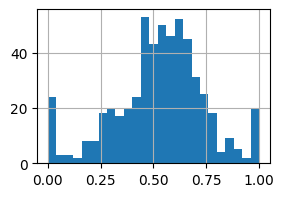

In [445]:
check(train, reference, col="name");

# Предварительная лемматизация, токенезация и удаление стоп-слов train и reference

In [446]:
import nltk
import pymorphy3
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Загружаем необходимые ресурсы

nltk.download("punkt")

nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\filat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [447]:
# Инициализация морфологического анализатора для русского языка
morph = pymorphy3.MorphAnalyzer()


# Пример функции для обработки текста
def preprocess_text(text):
    # Удаляем служебные символы (перенос строки, табуляция и т.д.)
    text = re.sub(r"[\n\t\r]", " ", text)

    # Удаление пунктуации
    text = re.sub(r"[^\w\s]", " ", text)

    # Удаление отдельных букв
    text = re.sub(r"\b[А-ЯЁа-яё]\b", " ", text)

    # Удаление лишних пробелов
    text = re.sub(r"\s+", " ", text)

    # Удаление пробелов в начале и в конце
    text = text.strip()

    # Токенизация
    words = word_tokenize(text.lower(), language="russian")

    # Лемматизация
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]

    # Удаление стоп-слов
    stop_words = set(stopwords.words("russian"))
    filtered_words = [word for word in lemmatized_words if word not in stop_words]

    return " ".join(filtered_words)

In [448]:
reference["exp2"] = reference.name.apply(preprocess_text)
train["exp2"] = train.name.apply(preprocess_text)

In [449]:
reference.head(10)

,id,name,region,exp2
0,69,Кировска,мурманская область,кировск
1,70,Клин спортивный,московская область,клин спортивный
2,71,КО СШ по ЗВС,калининградская область,сш звс
3,8,Айсберг,свердловская область,айсберг
4,73,Команда Дмитриева,челябинская область,команда дмитриев
5,74,Конаковский лед,тверская область,конаковский лёд
6,75,Конек Чайковской,москва,конёк чайковский
7,76,Контакт,ямало ненецкий автономный округ,контакт
8,77,Космос,воронежская область,космос
9,78,Космос,калужская область,космос


In [450]:
train.head(10)

,name,school_id,exp2
0,"Москва, ГБУ МАФКК школа ""Мечта""",102,москва гбу мафкк школа мечта
1,"Калужская область, СШ ""Космос""",78,калужский область сш космос
2,"МО 7-й округ, ООО ""Династия""",49,мо 7 округ ооо династия
3,АНФСО СКФК Спартак,164,анфсый скфк спартак
4,"Челябинская область, ИП Дмитриев А.А.",73,челябинский область ип дмитриев
5,"Санкт-Петербург, СПб ГБУ СШОР ""Звездный лед""""",62,санкт петербург спб гбу сшоры звёздный лёд
6,"ООО ""Вилеса Айс""",30,ооо вилеса айса
7,"НП ""КФК ""Динамо-Санкт-Петербург""",277,нп кфк динамо санкт петербург
8,"Пензенская область, МБУ ДО ""СШ по зимним видам...",304,пензенский область мбу сш зимний вид спорт
9,"Владимирская область, МБУ ДО ""СШ №8""",59,владимирский область мбу сш 8


### Проверка качества сравнения после лемматизации

,school_id,exp2,exp2_reference,similarity
515,96,москва гбу московский академия фигурный катани...,мафкк,0.0
491,257,спб гбу центр фксизый фрунза,цфксизый фрунзенский район,0.0
469,251,москва сшоры жук,цска,0.0
464,96,москва гбу московский академия фигурный катани...,мафкк,0.0
419,100,кемеровский обл маоу дод дюсш трудармейский,мбфс сш,0.0


,school_id,exp2,exp2_reference,similarity
328,246,красноярский край сш цплвс,центр лвс,0.000000
412,217,рязанский область,сшоры 6,0.000000
230,96,москва гбу мафк,мафкк,0.000000
523,227,гбпоу мо оур 1 московский область,уор 1,0.000000
2,49,мо 7 округ ооо династия,династия,0.526029
61,128,пермь сшоры орлёнок,орлёнок,0.607317
1,78,калужский область сш космос,космос,0.650808


'Кол-во записей со сходством 0                  - 20, 0.0364'

'Кол-во записей со сходством от 0.25 до 0.5     - 49, 0.0891'

'Кол-во записей со сходством от 0.5 до 0.75     - 151, 0.275'

'Кол-во записей со сходством больше 0.75        - 284, 0.516'

'Кол-во записей со сходством больше 0.99        - 20, 0.0364'

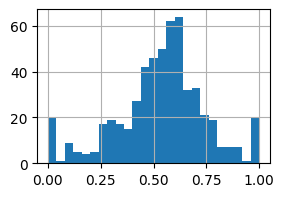

In [451]:
check(train, reference, col="exp2");

# exp3 - Без лемматизации

In [452]:
# Пример функции для обработки текста
def preprocess_text(text):
    # Удаляем служебные символы (перенос строки, табуляция и т.д.)
    text = re.sub(r"[\n\t\r]", " ", text)

    # Удаление пунктуации
    text = re.sub(r"[^\w\s]", " ", text)

    # Удаление отдельных букв
    text = re.sub(r"\b[А-ЯЁа-яё]\b", " ", text)

    # Удаление букв ё
    text = re.sub(r"[Ёё]", "е", text)

    # Удаление лишних пробелов
    text = re.sub(r"\s+", " ", text)

    # Удаление пробелов в начале и в конце
    text = text.strip()

    # Токенизация
    words = word_tokenize(text.lower(), language="russian")

    # Удаление стоп-слов
    stop_words = set(stopwords.words("russian"))
    filtered_words = [word for word in words if word not in stop_words]

    return " ".join(filtered_words)


In [453]:
reference["exp3"] = reference.name.apply(preprocess_text)
train["exp3"] = train.name.apply(preprocess_text)


### Проверка качества сравнения

,school_id,exp3,exp3_reference,similarity
479,5,айсдрим санкт петербург,ice dream айс дрим,0.0
515,96,москва гбу московская академия фигурного катан...,мафкк,0.0
523,227,гбпоу мо оур 1 московская область,уор 1,0.0
182,166,новгородская область,спорт индустрия,0.0
343,96,москва московская академия фигурного катания,мафкк,0.0


,school_id,exp3,exp3_reference,similarity
328,246,красноярский край сш цплвс,центр лвс,0.000000
412,217,рязанская область,сшор 6,0.000000
230,96,москва гбу мафк,мафкк,0.000000
523,227,гбпоу мо оур 1 московская область,уор 1,0.000000
2,49,мо 7 округ ооо династия,династия,0.526029
61,128,пермь сшор орленок,орленок,0.607317
1,78,калужская область сш космос,космос,0.650808


'Кол-во записей со сходством 0                  - 21, 0.0382'

'Кол-во записей со сходством от 0.25 до 0.5     - 52, 0.0945'

'Кол-во записей со сходством от 0.5 до 0.75     - 150, 0.273'

'Кол-во записей со сходством больше 0.75        - 281, 0.511'

'Кол-во записей со сходством больше 0.99        - 20, 0.0364'

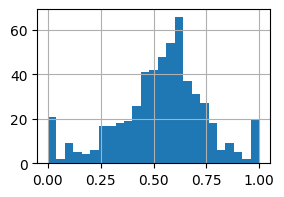

In [454]:
check(train, reference, col="exp3");

# exp4 - Расшифровка всех аббревиатур сразу

In [455]:
# abbr_dict = joblib.load("../../mats/abbreviations_dict.joblib")
joblib.dump(abbr_dict, "../../mats/abbreviations_dict.joblib")


['../../mats/abbreviations_dict.joblib']

In [539]:
abbr_dict = {
    "хмао": "ханты мансийский автономный округ",
    "югра": "",
    "динамо": "динамо",
    "история": "история",
    "олимпия": "олимпия",
    "сияние": "сияние",
    "пгуфксит": "поволжский государственный университет физической культуры спорта и туризма",
    "сит": "спорта и туризма",
    "ледовая": "ледовая",
    "шфкнк": "школа фигурного катания на коньках",
    "цпфких": "центр подготовки по фигурному катанию на коньках и хоккею",
    "восточная": "восточная",
    "физ": "физкультуры и здоровья",
    "надежды": "надежды",
    "фкких": "фигурному катанию на коньках и хоккею",
    "цфиз": "центр физкультуры и здоровья",
    "аго": "ангарский городской округ",
    "алвс": "академия ледовых видов спорта",
    "ано": "автономная некоммерческая организация",
    "анфсо": "автономная некоммерческая физкультурно-спортивная организация",
    "ао": "автономный округ",
    "ау": "автономное учреждение",
    "афк": "академия фигурного катания",
    "барс": "березники арена спорт",
    "бу": "бюджетное учреждение",
    "вдв": "воздушно-десантные войска",
    "витязь": "витязь",
    "во": "василеостровского района",
    "всшор": "всеволжская спортивная школа олимпийского резерва",
    "вфсо": "всероссийское физкультурно-спортивное общество",
    "гау": "государственное автономное учреждение",
    "гбоу": "государственное бюджетное образовательное учреждение",
    "гбпоу": "государственное бюджетное профессиональное образовательное учреждение",
    "гбу": "государственное бюджетное учреждение",
    "глайд": "глайд",
    "гоау": "государственное областное автономное учреждение",
    "гу": "государственное учреждение",
    "до": "дополнительного образования",
    "дод": "дополнительного образования детей",
    "дс": "дворец спорта",
    "дюсош": "детско-юношеская спортивно-оздоровительная школа",
    "дюсш": "детско-юношеская спортивная школа",
    "дюц": "детско-юношеский центр",
    "звс": "зимние виды спорта",
    "золотые": "золотые",
    "ио": "иркутская область",
    "ип": "индивидуальный предприниматель",
    "иро": "иркутское региональное отделение",
    "кгбу": "краевое государственное бюджетное учреждение",
    "кк": "краснодарского края",
    "ко": [
        "калужская область",
        "костромская область",
        "кировская область",
        "калининградская область",
    ],
    "когау": "кировское областное государственное автономное учреждение",
    "кроо": "краевая региональная общественная организация",
    "кфк": "клуб фигурного катания",
    "кфкнк": "клуб фигурного катания на коньках",
    "лвс": "ледовые виды спорта",
    "лд": "ледовый дворец",
    "лдс": "ледовый дворец спорта",
    "ло": "ленинградская Область",
    "лсвс": "ледовым видам спорта",
    "лск": "ледовый спортивный комплекс",
    "лц": "ледовый центр",
    "ма": "московская академия",
    "маоу": "муниципальное автономное образовательное учреждение",
    "мау": "муниципальное автономное учреждение",
    "маудо": "муниципальное автономное учреждение дополнительного образования",
    "маусш": "муниципальное автономное учреждение спортивная школа",
    "мафк": "московская академия фигурного катания на коньках",
    "мафкк": "московская академия фигурного катания на коньках",
    "мафсу": "муниципальное автономное физкультурно-спортивное учреждение",
    "мбоу": "муниципальное бюджетное образовательное учреждение",
    "мбу": "муниципальное бюджетное учреждение",
    "мбудо": "муниципальное бюджетное учреждение дополнительного образования",
    "мбус": "муниципальное бюджетное учреждение спорта",
    "мбфсу": "муниципальное бюджетное физкультурно-спортивное учреждение",
    "мдмис": "министерство по делам молодёжи и спорту",
    "мку": "муниципальное казенное учреждение",
    "мо": [
        "муниципального образования",
        "московской области",
        "мурманской области",
        "министерства обороны",
    ],
    "мо рф": "министерства обороны россии",
    "мо россии": "министерства обороны россии",
    "мосгорспорт": "московская дирекция по развитию массового спорта",
    "моу": "муниципальное образовательное учреждение",
    "му": "муниципальное учреждение",
    "наши": "наши",
    "нао": "ненецкий автономный округ",
    "нлфк": "национальная лига фигурного катания",
    "но": "нижегородская область",
    "нп": "некоммерческое партнерство",
    "огау": "областное государственное автономное учреждение",
    "ого": "общественно государственное объединение",
    "оксшор": "областная комплексная спортивная школа олимпийского резерва",
    "олимп": "олимп",
    "обл": "область",
    "оо": ["общественная организация", "общественное объединение"],
    "ооо": "общество с ограниченной ответственностью",
    "ооффк": "общественная организация федерация фигурного катания",
    "орк": "олимпийского резерва, комплексная",
    "оур": "училище техникум олимпийского резерва",
    "пбму": "первоуральское муниципальное бюджетное учреждение",
    "пмбу": "первоуральское муниципальное бюджетное учреждение",
    "по": "псковской области",
    "проо": "псковская региональная общественная организация",
    "рб": ["республика башкортостан", "республика беларусь"],
    "респ": "республика",
    "рк": [
        "республика карелия",
        "республика калмыкия",
        "республика коми",
        "республика крым",
        "республика казахстан",
    ],
    "рм": "республика мордовия",
    "рмэ": "республика марий эл",
    "ро": ["рязанская область", "региональное объединение", "ростовская область"],
    "роо": "региональная общественная организация",
    "роффкк": "ростовская областная федерация фигурного катания на коньках",
    "рс": "республика саха якутия",
    "рсоо": "региональная спортивная общественная организация",
    "рссш": "республики саха якутия спортивная школа",
    "рсшор": "республиканская спортивная школа олимпийского резерва",
    "рся": "республика саха якутия",
    "рт": "республика татарстан",
    "рф": "российская федерация",
    "рфсоо": "региональная физкультурно спортивная общественная организация",
    "рцсп": "региональный центр спортивной подготовки",
    "рцспзвс": "региональный центр спортивной подготовки по зимним видам спорта",
    "саха": "республики саха",
    "сбс": "сбс",
    "ск": "спортивный клуб",
    "ска": "спортивный клуб армии",
    "скфк": "спортивный клуб фигурного катания",
    "со": ["самарская область", "свердловская область", "смоленская область"],
    "согбу": "смоленское областное государственное бюджетное учреждение",
    "согбоу": "смоленское областное государственное бюджетное образовательное учреждение",
    "спб": "санкт петербург",
    "стартайс": "cтартайс",
    "стц": "спортивно тренировочный центр",
    "сфк": "секция фигурного катания",
    "сффк": "спортивная федерация фигурного катания на коньках",
    "сш": "спортивная школа",
    "сшор": "спортивная школа олимпийского резерва",
    "сшфкк": "спортивная школа фигурного катания",
    "тим": "тим",
    "титул": "титул",
    "то": "тульской области",
    "топ": "топ",
    "узор": "узор",
    "уор": "училище техникум олимпийского резерва",
    "ур": "удмуртской республики",
    "уффк": "удмуртская федерация фигурного катания",
    "фау": "федеральное автономное учреждение",
    "фк": "фигурного катания",
    "фкис": "физической культуры и спорта",
    "фкишт": "фигурному катанию на коньках и шорт треку",
    "фккишт": "фигурному катанию на коньках и шорт треку",
    "фкк": "фигурного катания на коньках",
    "фксиз": "физической культуры спорта и здоровья",
    "фок": "физкультурно оздоровительный комплекс",
    "фс": "физкультурно спортивное",
    "фск": "физкультурно спортивный комплекс",
    "фсо": "физкультурно спортивное объединение",
    "ффк": "федерация фигурного катания",
    "ффкк": "федерация фигурного катания на коньках",
    "ффккво": "федерация фигурного катания на коньках владимирской области",
    "ффккрк": "федерация фигурного катания на коньках республики коми",
    "ффккск": "федерация фигурного катания на коньках ставропольского края",
    "ффкпо": "федерация фигурного катания на коньках псковской области",
    "хк": "хоккейный клуб",
    "хшфк": "спортивный клуб по хоккею с шайбой и фигурному катанию",
    "цзвс": "центр зимних видов спорта",
    "цоп": "центр олимпийской подготовки",
    "цплвс": "центр по ледовым видам спорта",
    "цпср": "центр подготовки спортивного резерва",
    "црс": "центр развития спорта",
    "црфк": "центр развития фигурного катания",
    "цска": "центральный спортивный клуб армии",
    "цсп": "центр спортивной подготовки",
    "цфк": "центр физической культуры",
    "цфксиз": "центр физической культуры спорта и здоровья",
    "цфкиз": "центр физической культуры и здоровья",
    "цфкис": "центр физической культуры и спорта",
    "чоу": "частное образовательное учреждение",
    "чр": ["чувашская республика", "чеченская республика"],
    "чу": "частное учреждение",
    "чудо": "частное учреждение дополнительного образования",
    "шфк": "школа фигурного катания",
    "юнармейцы": "юнармецны",
    "янао": "ямало ненецкий автономный округ",
}


In [564]:
def preprocess_text(
    name,
    abbreviation_dict,
    output_list=False,
    unknown_answer=False,
    remove_unknown_abbr=False,
    remove_all_abbr=False,
):
    two_letter_prepositions = [
        " в ",
        " во ",
        " до ",
        " из ",
        " на ",
        " по ",
        " о ",
        " об ",
        " обо ",
        " у ",
    ]

    symbols = [" no", " NO", " No", "номер"]

    # Удаляем служебные символы (перенос строки, табуляция и т.д.)
    name = re.sub(r"[\n\t\r]", " ", name)

    # Создаем регулярное выражение для предлогов
    prepositions_pattern = (
        r"\b(?:" + "".join(two_letter_prepositions) + "".join(symbols) + r")\b"
    )

    # Заменяем все предлоги на пробем (предварительное решение вместо трудоемкого удаления стоп-слов)
    name = re.sub(prepositions_pattern, " ", name)

    # Удаление пунктуации
    name = re.sub(r"[^\w\s]", " ", name)

    # Удаление отдельных букв
    name = re.sub(r"\b[А-ЯЁа-яё]\b", " ", name)

    # Удаление букв ё
    name = re.sub(r"[Ёё]", "е", name)

    unknown_abbr = []
    # Находим аббревиатуры большими буквами и приводим их к нижнему регистру
    # Надо уточнить поиск неизвестных.
    # А если в конце аббревиатуры прописная буква?
    uppercase_abbreviations = re.findall(r"\b[А-ЯЁ]+[а-яё]*+[А-ЯЁ]+\b", name)
    for abbr in uppercase_abbreviations:
        abbr = abbr.lower()
        if abbr not in abbreviation_dict:
            unknown_abbr.append(abbr.upper())
            if remove_unknown_abbr:
                name = re.sub(r"\b" + re.escape(abbr.upper()) + r"\b", " ", name)

    # Удаление лишних пробелов
    name = re.sub(r"\s+", " ", name)

    # Удаление пробелов в начале и в конце
    name = name.strip()

    possible_replacements = []
    parts = name.lower().split()

    for part in parts:
        if part in abbreviation_dict:
            if not remove_all_abbr:
                replacements = abbreviation_dict[part]
                if isinstance(replacements, str):
                    replacements = [replacements]
                elif not output_list:
                    replacements = [""]
                possible_replacements.append(replacements)
            else:
                pass
        else:
            possible_replacements.append([part])

    # Генерируем все возможные комбинации
    all_combinations = list(itertools.product(*possible_replacements))

    # Формируем итоговые наименования
    final_phrases = [" ".join(combination).strip() for combination in all_combinations]

    if not output_list:
        final_phrases = final_phrases[0]

    if unknown_answer:
        return list(set(unknown_abbr))

    return final_phrases


In [458]:
reference["exp4"] = reference.name.apply(
    preprocess_text, args=(abbr_dict, False, False, False, False)
)
train["exp4"] = train.name.apply(
    preprocess_text, args=(abbr_dict, False, False, False, False)
)


### Проверка качества сравнения

,school_id,exp4,exp4_reference,similarity
394,128,пермский край пермь муниципальное автономное у...,орленок,0.0
182,166,новгородская область,спорт индустрия,0.0
469,251,москва спортивная школа олимпийского резерва и...,центральный спортивный клуб армии,0.0
319,128,муниципальное автономное учреждение спортивная...,орленок,0.0
4,73,челябинская область индивидуальный предпринима...,команда дмитриева,0.0


,school_id,exp4,exp4_reference,similarity
412,217,рязанская область,спортивная школа олимпийского резерва 6,0.000000
61,128,пермь спортивная школа олимпийского резерва ор...,орленок,0.000000
328,246,красноярский край спортивная школа центр по ле...,центр псковской области ледовые виды спорта,0.173788
523,227,государственное бюджетное профессиональное обр...,училище олимпийского резерва 1,0.494353
2,49,7 округ общество с ограниченной ответственност...,династия,0.539894
1,78,калужская область спортивная школа космос,космос,0.659447
230,96,москва государственное бюджетное учреждение до...,московская академия фигурного катания на коньках,0.712897


'Кол-во записей со сходством 0                  - 10, 0.0182'

'Кол-во записей со сходством от 0.25 до 0.5     - 24, 0.0436'

'Кол-во записей со сходством от 0.5 до 0.75     - 175, 0.318'

'Кол-во записей со сходством больше 0.75        - 260, 0.473'

'Кол-во записей со сходством больше 0.99        - 24, 0.0436'

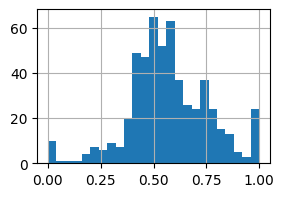

In [459]:
exp4_merged = check(train, reference, col="exp4")

### Обучим NER на распознавание городов на основе расшифрованных данных

In [460]:
region_list = [
    "алтайский край",
    "архангельская область",
    "астраханская область",
    "белгородская область",
    "брянская область",
    "владимирская область",
    "волгоградская область",
    "вологодская область",
    "воронежская область",
    "забайкальский край",
    "ивановская область",
    "иркутская область",
    "калининградская область",
    "калужская область",
    "кемеровская область",
    "кировская область",
    "костромская область",
    "краснодарский край",
    "красноярский край",
    "курганская область",
    "курская область",
    "ленинградская область",
    "липецкая область",
    "москва",
    "московская область",
    "мурманская область",
    "нижегородская область",
    "новгородская область",
    "новосибирская область",
    "омская область",
    "оренбургская область",
    "орловская область",
    "пензенская область",
    "пермский край",
    "приморский край",
    "псковская область",
    "республика башкортостан",
    "республика карелия",
    "республика коми",
    "республика крым",
    "республика марий эл",
    "республика мордовия",
    "республика саха",
    "республика татарстан",
    "ростовская область",
    "рязанская область",
    "самарская область",
    "санкт петербург",
    "саратовская область",
    "сахалинская область",
    "свердловская область",
    "севастополь",
    "смоленская область",
    "ставропольский край",
    "тамбовская область",
    "тверская область",
    "томская область",
    "тульская область",
    "тюменская область",
    "удмуртская республика",
    "хабаровский край",
    "ханты мансийский автономный округ",
    "челябинская область",
    "чувашская республика",
    "ямало ненецкий автономный округ",
    "ярославская область",
]


In [492]:
opf_list = [
    "автономная некоммерческая организация",
    "автономная некоммерческая физкультурно-спортивная организация",
    "государственное автономное учреждение",
    "государственное бюджетное образовательное учреждение",
    "государственное бюджетное профессиональное образовательное учреждение",
    "государственное бюджетное учреждение",
    "государственное областное автономное учреждение",
    "государственное учреждение",
    "дополнительного образования детей",
    "дополнительного образования",
    "индивидуальный предприниматель",
    "государственное бюджетное учреждение дополнительного образования",
    "краевое государственное бюджетное учреждение",
    "краевая региональная общественная организация",
    "муниципальное автономное образовательное учреждение",
    "муниципальное автономное учреждение дополнительного образования",
    "муниципальное автономное учреждение",
    "муниципальное автономное физкультурно-спортивное учреждение",
    "муниципальное бюджетное образовательное учреждение",
    "муниципальное бюджетное учреждение дополнительного образования",
    "муниципальное бюджетное учреждение спорта",
    "муниципальное бюджетное учреждение",
    "муниципальное бюджетное физкультурно-спортивное учреждение",
    "муниципальное казенное учреждение",
    "муниципальное образовательное учреждение",
    "областное государственное автономное учреждение",
    "общественно государственное объединение",
    "общество с ограниченной ответственностью",
    "региональная общественная организация",
    "региональная спортивная общественная организация",
    "региональная физкультурно спортивная общественная организация",
    "областное государственное бюджетное учреждение",
    "областное государственное бюджетное образовательное учреждение",
    "федеральное автономное учреждение",
    "частное образовательное учреждение",
    "частное учреждение дополнительного образования",
    "частное учреждение",
    "автономное учреждение",
    "общественная организация",
    "общественное объединение",
    "некоммерческое партнерство",
    "региональное отделение",
    "муниципальное учреждение",
    "бюджетное учреждение",
]


In [540]:
type_list = [
    "физической культуры спорта и туризма",
    "спорта и туризма",
    "школа фигурного катания на коньках",
    "центр подготовки по фигурному катанию на коньках и хоккею",
    "физкультуры и здоровья",
    "фигурному катанию на коньках и хоккею",
    "центр физкультуры и здоровья",
    "академия ледовых видов спорта",
    "академия фигурного катания",
    "спортивная школа олимпийского резерва",
    "всероссийское физкультурно-спортивное общество",
    "дворец спорта",
    "детско-юношеская спортивно-оздоровительная школа",
    "детско-юношеская спортивная школа",
    "детско-юношеский центр",
    "зимние виды спорта",
    "клуб фигурного катания",
    "клуб фигурного катания на коньках",
    "ледовые виды спорта",
    "ледовый дворец",
    "ледовый дворец спорта",
    "ледовым видам спорта",
    "ледовый спортивный комплекс",
    "ледовый центр",
    "московская академия",
    "московская академия фигурного катания на коньках",
    "московская академия фигурного катания на коньках",
    "министерства обороны россии",
    "министерства обороны россии",
    "национальная лига фигурного катания",
    "областная комплексная спортивная школа олимпийского резерва",
    "комплексная спортивная школа олимпийского резерва",
    "общественная организация федерация фигурного катания",
    "олимпийского резерва, комплексная",
    "училище техникум олимпийского резерва",
    "областная федерация фигурного катания на коньках",
    " федерация фигурного катания на коньках",
    "региональная спортивная общественная организация",
    "спортивная общественная организация",
    "республиканская спортивная школа олимпийского резерва",
    "спортивная школа олимпийского резерва",
    "республиканская спортивная школа",
    "региональная физкультурно спортивная общественная организация",
    "физкультурно спортивная общественная организация",
    "региональный центр спортивной подготовки",
    "региональный центр спортивной подготовки по зимним видам спорта",
    "спортивный клуб",
    "спортивный клуб армии",
    "спортивный клуб фигурного катания",
    "спортивно тренировочный центр",
    "секция фигурного катания",
    "спортивная федерация фигурного катания на коньках",
    "спортивная школа",
    "спортивная школа олимпийского резерва",
    "спортивная школа фигурного катания",
    "спортивная школа фигурного катания на коньках",
    "училище техникум олимпийского резерва",
    "фигурного катания",
    "физической культуры и спорта",
    "фигурному катанию на коньках и шорт треку",
    "фигурному катанию на коньках и шорт треку",
    "фигурного катания на коньках",
    "физической культуры спорта и здоровья",
    "физкультурно оздоровительный комплекс",
    "физкультурно спортивное",
    "физкультурно спортивный комплекс",
    "физкультурно спортивное объединение",
    "федерация фигурного катания",
    "федерация фигурного катания на коньках",
    "хоккейный клуб",
    "спортивный клуб по хоккею с шайбой и фигурному катанию",
    "центр зимних видов спорта",
    "центр олимпийской подготовки",
    "центр по ледовым видам спорта",
    "центр подготовки спортивного резерва",
    "центр развития спорта",
    "центр развития фигурного катания",
    "центральный спортивный клуб армии",
    "центр спортивной подготовки",
    "центр физической культуры",
    "центр физической культуры спорта и здоровья",
    "центр физической культуры и здоровья",
    "центр физической культуры и спорта",
    "школа фигурного катания",
]


In [541]:
ner_data = exp4_merged.exp4.tolist()
len(ner_data)


550

In [462]:
# `субъект РФ, город`
# [ОПФ]
# {округ, МО, район}
# 'название'
# {{тип учреждения}}




In [463]:
ner_train_data = ner_data[:500]
ner_test_data = ner_data[500:]


In [569]:
ner_train_data_processed = []

for name in ner_train_data:
    # Добавление кавычек для регионов
    for region in region_list:
        name = name.replace(region, f"`{region}`")

    # Добавление квадратных скобок для ОПФ
    sorted_opf_list = sorted(opf_list, key=len, reverse=True)

    # Замена элементов на уникальные маркеры
    marker_map = {}
    for i, opf in enumerate(sorted_opf_list):
        marker = f"__MARKER_{i}__"
        marker_map[marker] = opf
        name = name.replace(opf, marker)

    # Замена маркеров на элементы в квадратных скобках
    for marker, opf in marker_map.items():
        name = name.replace(marker, f"[{opf}]")

    # # Добавление подчеркиваний для ТИПА
    # sorted_type_list = sorted(type_list, key=len, reverse=True)

    # # Замена элементов на уникальные маркеры
    # marker_map = {}
    # for i, tpe in enumerate(sorted_type_list):
    #     marker = f"__MARKER_{i}__"
    #     marker_map[marker] = tpe
    #     name = name.replace(tpe, marker)

    # # Замена маркеров на элементы в квадратных скобках
    # for marker, tpe in marker_map.items():
    #     name = name.replace(marker, f"_{tpe}_")

    ner_train_data_processed.append(name)


ner_train_data_processed


['`москва` [государственное бюджетное учреждение] московская академия фигурного катания на коньках школа мечта',
 '`калужская область` спортивная школа космос',
 '7 округ [общество с ограниченной ответственностью] династия',
 '[автономная некоммерческая физкультурно-спортивная организация] спортивный клуб фигурного катания спартак',
 '`челябинская область` [индивидуальный предприниматель] дмитриев',
 '`санкт петербург` `санкт петербург` [государственное бюджетное учреждение] спортивная школа олимпийского резерва звездный лед',
 '[общество с ограниченной ответственностью] вилеса айс',
 '[некоммерческое партнерство] клуб фигурного катания динамо `санкт петербург`',
 '`пензенская область` [муниципальное бюджетное учреждение дополнительного образования] спортивная школа псковской области зимним видам спорта',
 '`владимирская область` [муниципальное бюджетное учреждение дополнительного образования] спортивная школа 8',
 '`самарская область` [муниципальное бюджетное учреждение дополнительног

In [570]:
def convert_to_train_data(texts):
    train_data = []
    for text in texts:
        entities = []
        clean_text = ""
        offset = 0

        while True:
            # Поиск сущностей LOC и OPF
            match_loc = re.search(r"`([^`]+)`", text)
            match_opf = re.search(r"\[([^\]]+)\]", text)

            # Определяем, что найдено первым (или вообще ничего не найдено)
            if not match_loc and not match_opf:
                break
            if match_loc and (not match_opf or match_loc.start() < match_opf.start()):
                match = match_loc
                entity_type = "LOC"
            else:
                match = match_opf
                entity_type = "OPF"

            start, end = match.span(1)
            entities.append((start - 1 + offset, end - 1 + offset, entity_type))

            # Обновление смещенного текста и общего смещения
            clean_text += text[: match.start()] + match.group(1)
            text = text[match.end() :]
            offset += start - 1 + len(match.group(1))

        clean_text += text  # Добавление оставшейся части текста
        train_data.append((clean_text, {"entities": entities}))

    return train_data


In [571]:
def convert_to_train_data(texts):
    train_data = []
    for text in texts:
        entities = []
        clean_text = ""
        offset = 0

        while True:
            # Поиск сущностей LOC, OPF и TPE
            match_loc = re.search(r"`([^`]+)`", text)
            match_opf = re.search(r"\[([^\]]+)\]", text)
            match_tpe = re.search(r"_([^\]]+)_", text)

            # Определяем, что найдено первым (или вообще ничего не найдено)
            matches = [(match_loc, "LOC"), (match_opf, "OPF"), (match_tpe, "TPE")]
            matches = [(m, t) for m, t in matches if m]

            if not matches:
                break

            match, entity_type = min(matches, key=lambda x: x[0].start())

            start, end = match.span(1)
            entities.append((start - 1 + offset, end - 1 + offset, entity_type))

            # Обновление смещенного текста и общего смещения
            clean_text += text[: match.start()] + match.group(1)
            text = text[match.end() :]
            offset += start - 1 + len(match.group(1))

        clean_text += text  # Добавление оставшейся части текста
        train_data.append((clean_text, {"entities": entities}))

    return train_data


In [572]:
# Преобразование данных
TRAIN_DATA = convert_to_train_data(ner_train_data_processed)


In [573]:
TRAIN_DATA

[('москва государственное бюджетное учреждение московская академия фигурного катания на коньках школа мечта',
  {'entities': [(0, 6, 'LOC'), (7, 43, 'OPF')]}),
 ('калужская область спортивная школа космос', {'entities': [(0, 17, 'LOC')]}),
 ('7 округ общество с ограниченной ответственностью династия',
  {'entities': [(8, 48, 'OPF')]}),
 ('автономная некоммерческая физкультурно-спортивная организация спортивный клуб фигурного катания спартак',
  {'entities': [(0, 61, 'OPF')]}),
 ('челябинская область индивидуальный предприниматель дмитриев',
  {'entities': [(0, 19, 'LOC'), (20, 50, 'OPF')]}),
 ('санкт петербург санкт петербург государственное бюджетное учреждение спортивная школа олимпийского резерва звездный лед',
  {'entities': [(0, 15, 'LOC'), (16, 31, 'LOC'), (32, 68, 'OPF')]}),
 ('общество с ограниченной ответственностью вилеса айс',
  {'entities': [(0, 40, 'OPF')]}),
 ('некоммерческое партнерство клуб фигурного катания динамо санкт петербург',
  {'entities': [(0, 26, 'OPF'), (57, 

In [574]:
import spacy
from spacy.training import Example
from spacy.util import minibatch, compounding
import random

# Создаем пустую модель для русского языка
nlp = spacy.blank("ru")

# Создаем NER компонент
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

# Добавляем метки в NER
for _, annotations in TRAIN_DATA:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

# Обучение модели
nlp.begin_training()

stop_factor = 9999
to_stop = 0

# Обучение модели
for itn in range(100):  # Количество эпох
    random.shuffle(TRAIN_DATA)
    losses = {}
    batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        for text, annotations in batch:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            nlp.update([example], drop=0.5, losses=losses)
    if losses["ner"] < stop_factor:
        stop_factor = losses["ner"]
        to_stop = 0
    else:
        to_stop += 1
    if to_stop > 2:
        break

    print(f"Losses at iteration {itn}: {losses}, to_stop: {to_stop}")


c:\Users\filat\Documents\goprotect\.venv\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "томская область детско-юношеская спортивная школа ..." with entities "[(1, 15, 'LOC')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
c:\Users\filat\Documents\goprotect\.venv\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "костромская область`` государственное бюджетное уч..." with entities "[(0, 5, 'LOC'), (22, 58, 'OPF')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


Losses at iteration 0: {'ner': 918.9829429164456}
Losses at iteration 1: {'ner': 396.7294478179274}
Losses at iteration 2: {'ner': 251.5433803786018}
Losses at iteration 3: {'ner': 204.13535627472055}
Losses at iteration 4: {'ner': 189.7891023865104}
Losses at iteration 5: {'ner': 163.84301715315084}
Losses at iteration 6: {'ner': 125.29029183881283}
Losses at iteration 7: {'ner': 95.89062354540434}
Losses at iteration 8: {'ner': 110.56145245099603}
Losses at iteration 9: {'ner': 73.35730520884117}
Losses at iteration 10: {'ner': 101.11010007118041}
Losses at iteration 11: {'ner': 91.55834377215491}


# Расшифровываем аббревиатуры и вырезаем регионы

In [620]:
reference["exp5"] = reference.name.apply(
    preprocess_text, args=(abbr_dict, False, False, False, False)
)
train["exp5"] = train.name.apply(
    preprocess_text, args=(abbr_dict, False, False, False, False)
)
valid["exp5"] = valid.name.apply(
    preprocess_text, args=(abbr_dict, False, False, False, False)
)


In [621]:
def extract_region(name, nlp, get_region=False):
    doc = nlp(name)
    new_name = name
    region = ""
    for ent in doc.ents:
        new_name = new_name.replace(ent.text, "")
        if ent.label_ == "LOC":
            region = ent.text

    # Удаление лишних пробелов
    new_name = re.sub(r"\s+", " ", new_name)
    # Удаление пробелов в начале и в конце
    new_name = new_name.strip()

    if not get_region:
        return new_name
    else:
        return region


In [622]:
reference["exp5"] = reference.exp5.apply(extract_region, args=(nlp,))
train["region"] = train.exp5.apply(extract_region, args=(nlp, True))
valid["region"] = valid.exp5.apply(extract_region, args=(nlp, True))
train["exp5"] = train.exp5.apply(extract_region, args=(nlp,))
valid["exp5"] = valid.exp5.apply(extract_region, args=(nlp,))


In [623]:
reference[["id", "region", "exp5"]].to_csv(
    "../../data/preprocessed/exp22/reference.csv", index=False
)
train[["exp5", "school_id", "region"]].to_csv(
    "../../data/preprocessed/exp22/train.csv", index=False
)
valid[["exp5", "school_id", "region"]].to_csv(
    "../../data/preprocessed/exp22/valid.csv", index=False
)


### Проверка качества сравнения

,school_id,exp5,exp5_reference,similarity
182,166,,спорт индустрия,0.0
479,5,айсдрим,ice dream айс дрим,0.0
469,251,спортивная школа олимпийского резерва им жука,центральный спортивный клуб армии,0.0
412,217,,спортивная школа олимпийского резерва 6,0.0
194,5,айсдрим,ice dream айс дрим,0.0


'Кол-во записей со сходством 0                  - 6, 0.0109'

'Кол-во записей со сходством от 0 до 0.25     - 12, 0.0218'

'Кол-во записей со сходством от 0.25 до 0.5     - 50, 0.0909'

'Кол-во записей со сходством от 0.5 до 0.75     - 201, 0.365'

'Кол-во записей со сходством от 0.75 до 0.99     - 147, 0.267'

'Кол-во записей со сходством больше 0.99        - 140, 0.255'

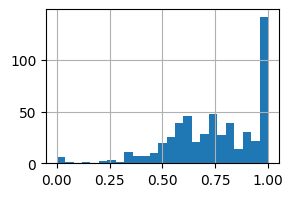

In [640]:
check(train, reference, col="exp5");

,school_id,exp5,exp5_reference,similarity
173,10,аскк,академия синхронного катания на коньках,0.000000
125,244,московская академия фигурного катания на коньк...,хрустальный,0.000000
38,112,спортивный клуб фигурного катания на коньках о...,национальная лига фигурного катания,0.169659
117,287,черникова наталья александровна,секция фигурного катания узор баранчикова ната...,0.227518
170,201,республиканская спортивная школа олимпийского ...,спортивная школа олимпийского резерва псковско...,0.271594


'Кол-во записей со сходством 0                  - 2, 0.011'

'Кол-во записей со сходством от 0 до 0.25     - 4, 0.022'

'Кол-во записей со сходством от 0.25 до 0.5     - 20, 0.11'

'Кол-во записей со сходством от 0.5 до 0.75     - 71, 0.39'

'Кол-во записей со сходством от 0.75 до 0.99     - 41, 0.225'

'Кол-во записей со сходством больше 0.99        - 46, 0.253'

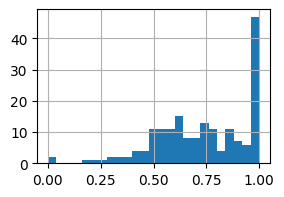

In [641]:
check(valid, reference, col="exp5");

In [643]:
merged_train.head()

,name,school_id,exp2,exp3,exp4,exp5,region,name_reference,region_reference,exp2_reference,exp3_reference,exp4_reference,exp5_reference
0,"Москва, ГБУ МАФКК школа ""Мечта""",102,москва гбу мафкк школа мечта,москва гбу мафкк школа мечта,москва государственное бюджетное учреждение мо...,московская академия фигурного катания на коньк...,москва,Мечта,москва,мечта,мечта,мечта,мечта
1,"Калужская область, СШ ""Космос""",78,калужский область сш космос,калужская область сш космос,калужская область спортивная школа космос,спортивная школа космос,калужская область,Космос,калужская область,космос,космос,космос,космос
2,"МО 7-й округ, ООО ""Династия""",49,мо 7 округ ооо династия,мо 7 округ ооо династия,7 округ общество с ограниченной ответственност...,7 округ династия,,Династия,санкт петербург,династия,династия,династия,династия
3,АНФСО СКФК Спартак,164,анфсый скфк спартак,анфсо скфк спартак,автономная некоммерческая физкультурно-спортив...,спортивный клуб фигурного катания спартак,,Спартак,санкт петербург,спартак,спартак,спартак,спартак
4,"Челябинская область, ИП Дмитриев А.А.",73,челябинский область ип дмитриев,челябинская область ип дмитриев,челябинская область индивидуальный предпринима...,дмитриев,челябинская область,Команда Дмитриева,челябинская область,команда дмитриев,команда дмитриева,команда дмитриева,команда дмитриева


In [663]:
merged_train = train.join(
    reference.set_index("id"), on="school_id", how="left", rsuffix="_reference"
)
merged_train = merged_train[~merged_train.name_reference.isna()]
merged_train = merged_train[~merged_train.exp5.isna()]
merged_train[["exp5", "exp5_reference"]].to_csv(
    "../../data/preprocessed/exp23/merged_train.csv", index=False
)

merged_valid = valid.join(
    reference.set_index("id"), on="school_id", how="left", rsuffix="_reference"
)
merged_valid = merged_valid[~merged_valid.name_reference.isna()]
merged_valid = merged_valid[~merged_valid.exp5.isna()]
merged_valid[["exp5", "exp5_reference"]].to_csv(
    "../../data/preprocessed/exp23/merged_valid.csv", index=False
)


# Описание предобработки

### Проверка качества сравнения

In [ ]:
# check(train, reference, col="")

# Описание предобработки

### Проверка качества сравнения

In [ ]:
# check(train, reference, col="")

# Описание предобработки

### Проверка качества сравнения

In [ ]:
# check(train, reference, col="")

# Описание предобработки

### Проверка качества сравнения

In [ ]:
# check(train, reference, col="")

In [25]:
locations = ["Москва", "Санкт-Петербург", "Казань"]
organizations = ["Московская государственная школа", "Гимназия", "Лицей"]

In [26]:
def create_training_data(texts, locations, organizations):
    training_data = []

    for text in texts:
        entities = []

        # Поиск и разметка локаций
        for loc in locations:
            for match in re.finditer(re.escape(loc), text):
                start, end = match.span()
                entities.append((start, end, "LOC"))

        # Поиск и разметка организаций
        for org in organizations:
            for match in re.finditer(re.escape(org), text):
                start, end = match.span()
                entities.append((start, end, "ORG"))

        training_data.append((text, {"entities": entities}))

    return training_data


# Пример текстов
texts = [
    "Московская государственная школа номер один",
    "Гимназия номер два в Санкт-Петербурге",
    "Лицей номер три в Казани",
]

# Создание тренировочных данных
TRAIN_DATA = create_training_data(texts, locations, organizations)
print(TRAIN_DATA)

[('Московская государственная школа номер один', {'entities': [(0, 32, 'ORG')]}), ('Гимназия номер два в Санкт-Петербурге', {'entities': [(21, 36, 'LOC'), (0, 8, 'ORG')]}), ('Лицей номер три в Казани', {'entities': [(0, 5, 'ORG')]})]
